![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1
import numpy as np

max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, -np.inf]

    X = X.copy()
    for col in X.select_dtypes(include=['bool']).columns:
        X[col] = X[col].astype(int)


    def mse(y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y))**2)

    for j in features:
        column = X.iloc[:, j]

        if len(np.unique(column)) == 1:
            continue

        splits = np.percentile(column, np.linspace(0, 100, num_pct + 2)[1:-1])
        splits = np.unique(splits)

        for split in splits:
            mask = column < split
            y_left, y_right = y[mask], y[~mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            mse_parent = mse(y)
            mse_left = mse(y_left)
            mse_right = mse(y_right)
            n_total = len(y)
            gain = mse_parent - (len(y_left)/n_total * mse_left + len(y_right)/n_total * mse_right)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

(0, np.float64(2014.0), np.float64(8706079.2690802))

🟢 Procedimiento y explicación

1. Ahora verifico el split seleccionado por la función para ver como es estan dividiendo los datos
2. Verifico que no este generando ramas vacias al momento de hacer la divisón, lo cual no sucede ya que al sumar el lado de la derecha e izquieda, da la cantidad usada en y_train
3. Ahora corro la función tree_grow con X_train y X_test

In [ ]:
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]
y_train.shape[0], y_l.shape[0], y_r.shape[0]

(7031, 2270, 4761)

In [ ]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if len(y) <= 1:
        return {'value': np.mean(y), 'level': level, 'split': -1, 'n_samples': len(y)}

    j, split, gain = best_split(X, y, num_pct)

    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return {'value': np.mean(y), 'level': level, 'split': -1, 'n_samples': len(y)}

    mask = X.iloc[:, j] < split
    return {'split': [j, split],
        'value': np.mean(y),
        'level': level,
        'n_samples': len(y),
        'gain': gain,
        'left': tree_grow(X[mask], y[mask], level+1, min_gain, max_depth, num_pct),
        'right': tree_grow(X[~mask], y[~mask], level+1, min_gain, max_depth, num_pct)}

tree = tree_grow(X_train, y_train, max_depth=2, num_pct=10)
tree

{'split': [0, np.float64(2014.0)],
 'value': np.float64(14508.073389276064),
 'level': 0,
 'n_samples': 7031,
 'gain': np.float64(8706079.2690802),
 'left': {'split': [0, np.float64(2012.0)],
  'value': np.float64(10234.929955947136),
  'level': 1,
  'n_samples': 2270,
  'gain': np.float64(4019659.1499605672),
  'left': {'value': np.float64(8737.28071379547),
   'level': 2,
   'split': -1,
   'n_samples': 1457},
  'right': {'value': np.float64(12918.90897908979),
   'level': 2,
   'split': -1,
   'n_samples': 813}},
 'right': {'split': [0, np.float64(2017.0)],
  'value': np.float64(16545.467968914094),
  'level': 1,
  'n_samples': 4761,
  'gain': np.float64(1524388.1958712116),
  'left': {'value': np.float64(15976.070045848192),
   'level': 2,
   'split': -1,
   'n_samples': 3926},
  'right': {'value': np.float64(19222.66107784431),
   'level': 2,
   'split': -1,
   'n_samples': 835}}}

🟢 Procedimiento y explicación

1. ahora con la función tree_predict, realizo predicciones usando X_train y luego nuevamente pero con X_test.
2. Genero las metricas del MAE y el RMSE para que el desempeño del test

In [ ]:
def tree_predict(X, tree, proba=False):
    predicted = np.zeros(X.shape[0])

    if 'split' not in tree or tree['split'] == -1:
        return np.full(X.shape[0], tree['value'])

    j, split = tree['split']
    filter_l = X.iloc[:, j] < split
    X_l, X_r = X[filter_l], X[~filter_l]

    if 'left' in tree and 'right' in tree:
        predicted[filter_l] = tree_predict(X_l, tree['left'], proba)
        predicted[~filter_l] = tree_predict(X_r, tree['right'], proba)
    else:
        predicted[:] = tree['value']

    return predicted

y_pred = tree_predict(X_train, tree)

df_predicciones = X_train.copy()
df_predicciones["Predicción"] = y_pred
df_predicciones["Real"] = y_train

df_predicciones

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,Predicción,Real
318288,2014,39988,False,False,False,False,False,True,False,15976.070046,18495
333638,2007,38904,False,False,False,False,True,False,False,8737.280714,10891
234716,2016,29607,False,False,False,False,False,True,False,15976.070046,18994
208752,2014,50756,False,False,False,False,False,True,False,15976.070046,13691
348892,2017,10506,False,False,False,False,False,True,False,19222.661078,19999
...,...,...,...,...,...,...,...,...,...,...,...
218085,2010,84057,False,False,False,False,True,False,False,8737.280714,9995
198455,2012,93770,False,True,False,False,False,False,False,12918.908979,12898
205572,2010,88644,False,False,True,False,False,False,False,8737.280714,8988
33541,2015,26180,False,False,False,False,False,True,False,15976.070046,18995


In [ ]:
y_pred = tree_predict(X_test, tree)

df_predicciones = X_test.copy()
df_predicciones["Predicción"] = y_pred
df_predicciones["Real"] = y_test

df_predicciones

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,Predicción,Real
257343,2012,62048,False,False,False,False,True,False,False,12918.908979,9900
326011,2005,111565,False,True,False,False,False,False,False,8737.280714,6987
242354,2014,24203,False,False,False,False,False,True,False,15976.070046,15814
266376,2015,30475,False,False,False,False,False,False,True,15976.070046,17997
396954,2014,30498,False,False,False,False,False,False,True,15976.070046,18938
...,...,...,...,...,...,...,...,...,...,...,...
144298,2016,39544,False,False,False,False,False,True,False,15976.070046,17988
364521,2015,37109,False,False,False,False,False,False,True,15976.070046,19995
120072,2017,27341,False,False,False,False,False,True,False,19222.661078,18330
99878,2012,78959,False,True,False,False,False,False,False,12918.908979,10495


In [ ]:
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print('El MAE del conjunto de test es:', mae)
print('El RMSE del conjunto de test es:', rmse)

El MAE del conjunto de test es: 1637.1349204706257
El RMSE del conjunto de test es: 2128.8874044922427


🟢 Interpretación de los resultados.

1. Teniendo en cuenta que el promedio de venta de los carros es de 14.538 dolares, según el MAE, el modelo se equivoca en promedio unos 1.637 dolares, lo que significaria un 11.3% del precio de los carros.
2. Para el caso de RMSE, que penaliza los errores mas grandes, el error ronda el 14.6%, lo que puede indicar que hay errores mucho mas grandes en las predicciones pero no lo suficiente para desestabilziar el modelo

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
import numpy as np

In [ ]:
# Celda 2

# Bagging manual

# Paso 1: hacer muestras con bootstrap para cada arbol, del mismo tamaño de observaciones que en train
observaciones_por_muestra = X_train.shape[0]
cantidad_de_muestras = 10 # 10 arboles

# list comprehension para crear las 10 muestras
np.random.seed(123)
muestras = [np.random.choice(a=observaciones_por_muestra, size=observaciones_por_muestra, replace=True) for muestra in range(cantidad_de_muestras)]

for i in range(len(muestras)):
    print(f"Muestra {i} de tamaño {len(muestras[i])}: ")
    print(muestras[i])

Muestra 0 de tamaño 7031: 
[3582 3454 1346 ...  826  801 5657]
Muestra 1 de tamaño 7031: 
[6962 3408 2553 ... 6611  877 6412]
Muestra 2 de tamaño 7031: 
[1917 3131  384 ... 2876 6449 6557]
Muestra 3 de tamaño 7031: 
[3849 4565 6820 ... 6835 4643  639]
Muestra 4 de tamaño 7031: 
[2468 3608 1367 ... 3108 2961 4357]
Muestra 5 de tamaño 7031: 
[3142 1537 5966 ... 3224 6922 3396]
Muestra 6 de tamaño 7031: 
[6588 3753 1786 ... 2131 4627 5672]
Muestra 7 de tamaño 7031: 
[1289 3776  981 ... 1891 6034 6165]
Muestra 8 de tamaño 7031: 
[6079 3819 6976 ... 6478 2225 5072]
Muestra 9 de tamaño 7031: 
[3952 3276  896 ... 4589 1964  893]


In [ ]:
# Paso 2 crear los arboles con las diferentes muestras creadas en el paso anterior
from sklearn.tree import DecisionTreeRegressor

# definicion del objeto de decision tree reg
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# dataframe para guardar las predicciones (columnas = cantidad de arboles, filas = los indices de las observaciones en test)
y_pred_bag_manual = pd.DataFrame(index=X_test.index, columns=list(range(cantidad_de_muestras)))

y_pred_bag_manual.head()

,0,1,2,3,4,5,6,7,8,9
257343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i, sample in enumerate(muestras):
    # seleccionar por posicion (iloc) las observaciones en X_train
    xtrain = X_train.iloc[sample, :]
    ytrain = y_train.iloc[sample]
    treereg.fit(xtrain, ytrain)
    y_pred_bag_manual.iloc[:,i] = treereg.predict(X_test)

y_pred_bag_manual

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [ ]:
# desempeño de cada arbol
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_bag_manual = []
mae_bag_manual = []
for i in range(cantidad_de_muestras):
    rmse = np.sqrt(mean_squared_error(y_pred_bag_manual.iloc[:,i], y_test))
    mae = mean_absolute_error(y_test,y_pred_bag_manual.iloc[:,i])
    rmse_bag_manual.append(rmse)
    mae_bag_manual.append(mae)
    print(f"Arbol {i} tiene un RMSE de: {rmse} y un MAE de {mae}")

Arbol 0 tiene un RMSE de: 2141.613353645869 y un MAE de 1605.3012605850654
Arbol 1 tiene un RMSE de: 2136.3519863123465 y un MAE de 1589.8544072363356
Arbol 2 tiene un RMSE de: 2122.718759132052 y un MAE de 1577.7323421862973
Arbol 3 tiene un RMSE de: 2087.278992468617 y un MAE de 1569.6103493071594
Arbol 4 tiene un RMSE de: 2168.518742842026 y un MAE de 1614.8178695150114
Arbol 5 tiene un RMSE de: 2113.8811455834793 y un MAE de 1576.055638953041
Arbol 6 tiene un RMSE de: 2127.933470769012 y un MAE de 1582.1453521939954
Arbol 7 tiene un RMSE de: 2184.414847251443 y un MAE de 1606.3077848344878
Arbol 8 tiene un RMSE de: 2138.1071697514985 y un MAE de 1586.4345169361045
Arbol 9 tiene un RMSE de: 2132.097520859104 y un MAE de 1587.769866243264


In [ ]:
# Paso 3: agregar las predicciones de los arboles

# agregar una columna que promedie las demas columnas para obtener la prediccion del bagging
y_pred_bag_manual['final'] = y_pred_bag_manual.mean(axis=1)
y_pred_bag_manual.head()

,0,1,2,3,4,5,6,7,8,9,final
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0,13767.4
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0,6243.1
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0,16694.3
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0,20865.3
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0,16468.1


In [ ]:
# medir el desempeño
rmse_bagging = np.sqrt(mean_squared_error(y_pred_bag_manual['final'],y_test))
mae_bagging = mean_absolute_error(y_test, y_pred_bag_manual['final'])

rmse_bag_manual.append(rmse_bagging)
mae_bag_manual.append(mae_bagging)

print(f"El RMSE al promediar todos los arboles es de: {rmse_bagging} y el MAE es de: {mae_bagging}")

El RMSE al promediar todos los arboles es de: 1796.4355868399332 y el MAE es de: 1340.0160739030025


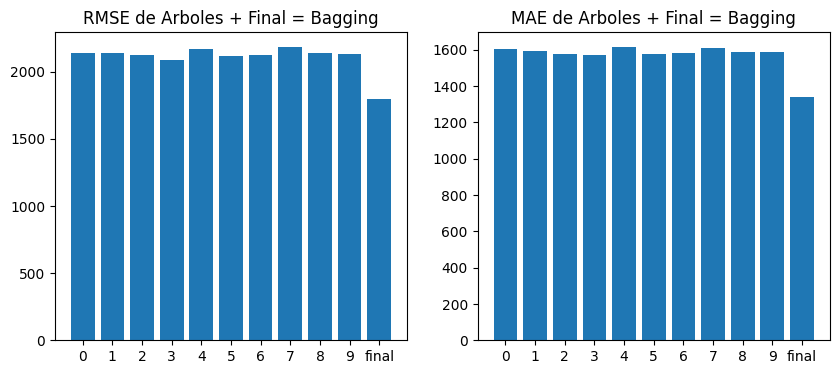

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].bar(x=y_pred_bag_manual.columns.astype(str), height=rmse_bag_manual)
ax[0].set_title("RMSE de Arboles + Final = Bagging")

ax[1].bar(x=y_pred_bag_manual.columns.astype(str), height=mae_bag_manual)
ax[1].set_title("MAE de Arboles + Final = Bagging")
plt.show()

🟢 **Procedimiento**

Para la creación del Bagging manualmente, segúi los siguientes pasos:

1. Crear las muestras de bootstrap (10 - una para cada árbol) y almacenarlas en una lista de listas
2. Crear el objeto de sklearn con las especificaciones de los árboles y un dataframe vacío para almacenar resultados de cada árbol
3. Iterar sobre las muestras para ajustar un árbol a cada muestra, llenando el dataframe previamente creado con las predicciones de cada árbol
4. Crear una columna final del dataframe en donde se promedien los valores de las demás columnas (predicciones de cada árbol) en la misma fila para obtener la **agregación de los modelos = Bagging**
5. Graficar resultados

🟢 **Análisis y Conclusiones**

Se observa claramente en las gráficas de $RMSE$ y $MAE$ que la aggregación de los 10 árboles tiene un mejor desempeño que cualquiera de los 10 modelos individuales. Con esto podemos concluir que, en este caso, el algoritmo de Bagging, mejoró significativamente las predicciones, disminuyendo la varianza de los modelos individuales, obteniendo un $RMSE$ de 1796.4 y el $MAE$ es de: 1340.01, cuando el árbol individual con mejor desempeño obtuvo un $RMSE$ 2087.2 de y un $MAE$ de 1569.61.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
from sklearn.ensemble import BaggingRegressor

bagreg = BaggingRegressor(DecisionTreeRegressor(max_features='log2'), n_estimators=10, bootstrap=True, oob_score=True, random_state=1)
bagreg.fit(X_train, y_train)
y_pred_bag_libreria = bagreg.predict(X_test)
y_pred_bag_libreria

array([13011.8,  6612.8, 16692.6, ..., 22596.4, 12990.6, 11969.1])

In [ ]:
# medir el desempeño
rmse_bag_libreria = np.sqrt(mean_squared_error(y_pred_bag_libreria, y_test))
mae_bag_libreria = mean_absolute_error(y_test, y_pred_bag_libreria)
print(f"El RMSE de Bagging con libreria sklearn es {rmse_bag_libreria} y el MAE es {mae_bag_libreria}")

El RMSE de Bagging con libreria sklearn es 1824.7000069648657 y el MAE es 1361.8777493561897


🟢 **Procedimiento**

Siguiendo la estructura de la creación de un modelo con sklearn:

1. Se crea el objeto de BaggingRegressor con los parámetros especificados
2. Se ajusta el modelo a los datos de entrenamiento con `fit`
3. Se obtienen las predicciones con `predict`
4. Se mide el desempeño comparando con test

🟢 **Análisis y Conclusiones**

Se observa que el $RMSE$ y $MAE$ del árbol con sklearn igualmente mejora el desempeño de los árboles individuales que se crearon en el punto anterior, sin embargo, a comparación con el método de agregación manual, el algoritmo de sklearn obtuvo un desempeño ligeramente peor al de la agregación manual.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

🟢 Procedimiento y explicación

1. Uso las librerias de sklearn para llamar en Random Forest para regresión
2. Establesco el modelo con parametros estandar
3. realizo cross validation sobre las muestras de train
4. Ahora realizo las predicciones tanto en train como en test
5. Tambien uso la libreria de sklearn para calcular el MAE y el RMSE, En el caso del RMSE realice la raiz cuadrada de manera manual ya que generaba un error

In [ ]:
# Celda 4

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

modelo_rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)

pd.Series(cross_val_score(modelo_rf, X_train, y_train, cv=10))


modelo_rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
y_pred_train_rf = modelo_rf.predict(X_train)
y_pred_test_rf = modelo_rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_rf = modelo_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("MAE:", mae_rf)
print("RMSE:", rmse_rf)

MAE: 1314.4207078056425
RMSE: 1765.4118259983413


🟢 Interpretación de los resultados.

1. Las metricas del random forents muestran una mejora considerable a diferencia del árbol de decision manual. Tanto el MAE como SMSE son mas bajos.
2. Recordando que el precio promedio de los carros es de 14.538, el MAE del random forest dice que el modelo se esta equivocando en un 9%, a diferencia del 11.3% del árbol manual.
3. El RMSE establece un error del 12.14% a diferencia del 14.6% del árbol manual.
4. Esto significa que el Random Forest predice mejor que el modelo deárbol manual

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

🟢 Procedimiento y explicación

1. Siguiendo el ejemplo del laboratorio, realizo la busqueda de los mejores parametros para calibrar el modelo de random forest. En este caso usando como referencia ya metrica del RMSE, ya que se trata de un problema de regresión.
2. en el caso de la cantidad apropiada de arboles a construir, el RMSE más bajo esta en torno a los 250 árboles. En este punto, noto que se demora en encontrar el parametro, por lo que el costo computaciones es considerable.
3. En el caso del número de variables a considerar, el RMSE mas bajo es en 9 variables (todas en este caso). Tambien se detecta un costo computacional considerable para encontrar este hiperparametro. En este caso, escogo como valor para el max_features el 7, ya que esto puede brindar mayor diversidad al modelo y asi evitar la correlación entre los arboles que podria ocacionar escoger todas las variables (9).

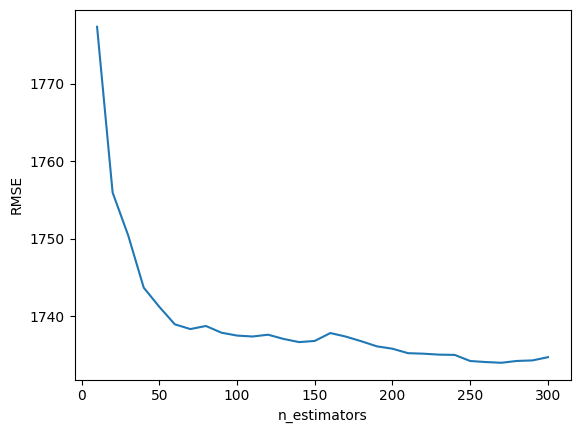

In [ ]:
# Celda 5

import matplotlib.pyplot as plt

estimator_range = range(10, 310, 10)

rmse_scores = []

for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=42, n_jobs=-1)
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())


plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

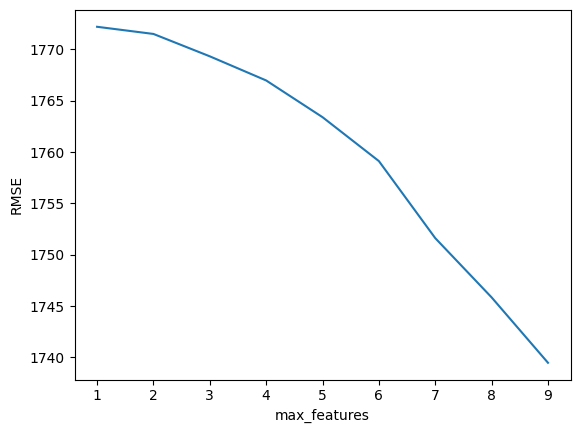

In [ ]:
feature_range = range(1, len(X_train.columns) + 1)

rmse_scores = []


for feature in feature_range:
    reg = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.show()

In [ ]:
modelo_rf_calib = RandomForestRegressor(n_estimators=250, max_features=7, max_depth=None, random_state=42, n_jobs=-1)

pd.Series(cross_val_score(modelo_rf_calib, X_train, y_train, cv=10))

modelo_rf_calib.fit(X_train, y_train)

RandomForestRegressor(max_features=7, n_estimators=250, n_jobs=-1,
                      random_state=42)

In [ ]:
y_pred_train_rf_calib = modelo_rf_calib.predict(X_train)
y_pred_test_rf_calib = modelo_rf_calib.predict(X_test)


mae_rf_calib = mean_absolute_error(y_test, y_pred_test_rf_calib)
rmse_rf_calib = np.sqrt(mean_squared_error(y_test, y_pred_test_rf_calib))

print("MAE:", mae_rf_calib)
print("RMSE:", rmse_rf_calib)

MAE: 1319.8542673360125
RMSE: 1771.2483295940337


🟢 Interpretación de los resultados.

1. Los resultados de la metricas de este modelo calibrado demuestran una mejora considerable. El MAE se reduce en un 30% y el RMSE en un 26% si se compara con el árbol manual.
2. En comparación con el random forest sin calibrar, el modelo con calibracion reduce ambas metricas en un 12%
3. En este sentido, el modelo calibrado es mucho mejor.
4. El cambio del parametro n_estimators, significo que redujo la varianza, a pesar de que esto significo un mayor costo computacional. De esta forma, aumentar los árboles permitio que reducir el error de predicción.
5. Respecto al cambio en max_features, permitio que cada árbol este menos correlacionado con los otros, logrando que entre todos tengan un mejor desempeño.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Crear modelo de regresion
reg_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Entrenar el modelo
reg_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = reg_model.predict(X_test)

# Calcular métricas de evaluación
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xg = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"RMSE: {rmse_xg:.2f}")
print(f"MAE: {mae_xg:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 1605.24
MAE: 1185.23
R²: 0.83


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Definición del modelo base
reg_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definición condiciones de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 1, 5],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(
    estimator=reg_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Entrenamiento con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_

# Predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

# Evaluación
rmse_xg_calibrado = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xg_calibrado = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Resultados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print(f"RMSE: {rmse_xg_calibrado:.2f}")
print(f"MAE: {mae_xg_calibrado:.2f}")
print(f"R²: {r2:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros encontrados:
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
RMSE: 1547.96
MAE: 1138.01
R²: 0.84


##### **ANALISIS Y CONCLUSIONES**

Se realizo un procedimiento para encontrar los valores optimos de los parametros `learning rate`, `gamma` y `colsample_bytree` del modelo XGBoost para regresión, el valor optimo se define como el valor que toman estos parametros donde se obtiene el mejor resultado en metricas de desempeño $RMSE$, $MAE$ y $R^2$.

Se encuentran estos valores optimos:
* `learning_rate` = 0.1
* `gamma` = 0
* `colsample_bytree` = 0.5

Al calibrar los hiperparametros del modelo XGBOOST con esta configuración, se obtienen los siguientes resultados:

* $RMSE$ = Se reduce el error cuadratico medio de 1605.2 a 1544.2 lo que mejora 3.78% el desempeño del modelo.
* $MAE$ = Se reduce el MAE de 1185.2 a 1138.0 con la calibracion de parametros, lo que mejora 3.9% el desempeño del modelo.
* $R^2$ = Mejora el coeficiente de determinacion de 0.83 a 0.84, lo que equivale a una mejora del 1.2%.


Estas mejoras aunque no fueron tan significativas son importantes para mejorar el performance del modelo, con estos resultados se puede decir que el modelo aumento la capacidad para explicar la variabuilidad de los datos y realizar predicciones mas precisas.

**Efecto de cada parámetro:**

learning_rate: controla la tasa de aprendizaje del modelo. Un valor más bajo puede llevar a un entrenamiento más estable y preciso, pero requiere más árboles y por lo tanto mas tiempo (Procesamiento). Un valor más alto puede causar sobreajuste si no se controla adecuadamente.

gamma: establece una penalización para la complejidad del árbol. Un valor mayor reduce la tendencia al sobreajuste al exigir una mejora mínima en la función objetivo antes de dividir un nodo.

colsample_bytree: determina la fracción de columnas (features) que se muestrean al construir cada árbol. Valores menores pueden reducir el sobreajuste y mejorar la generalización, pero valores demasiado bajos pueden llevar a una pérdida de información importante.

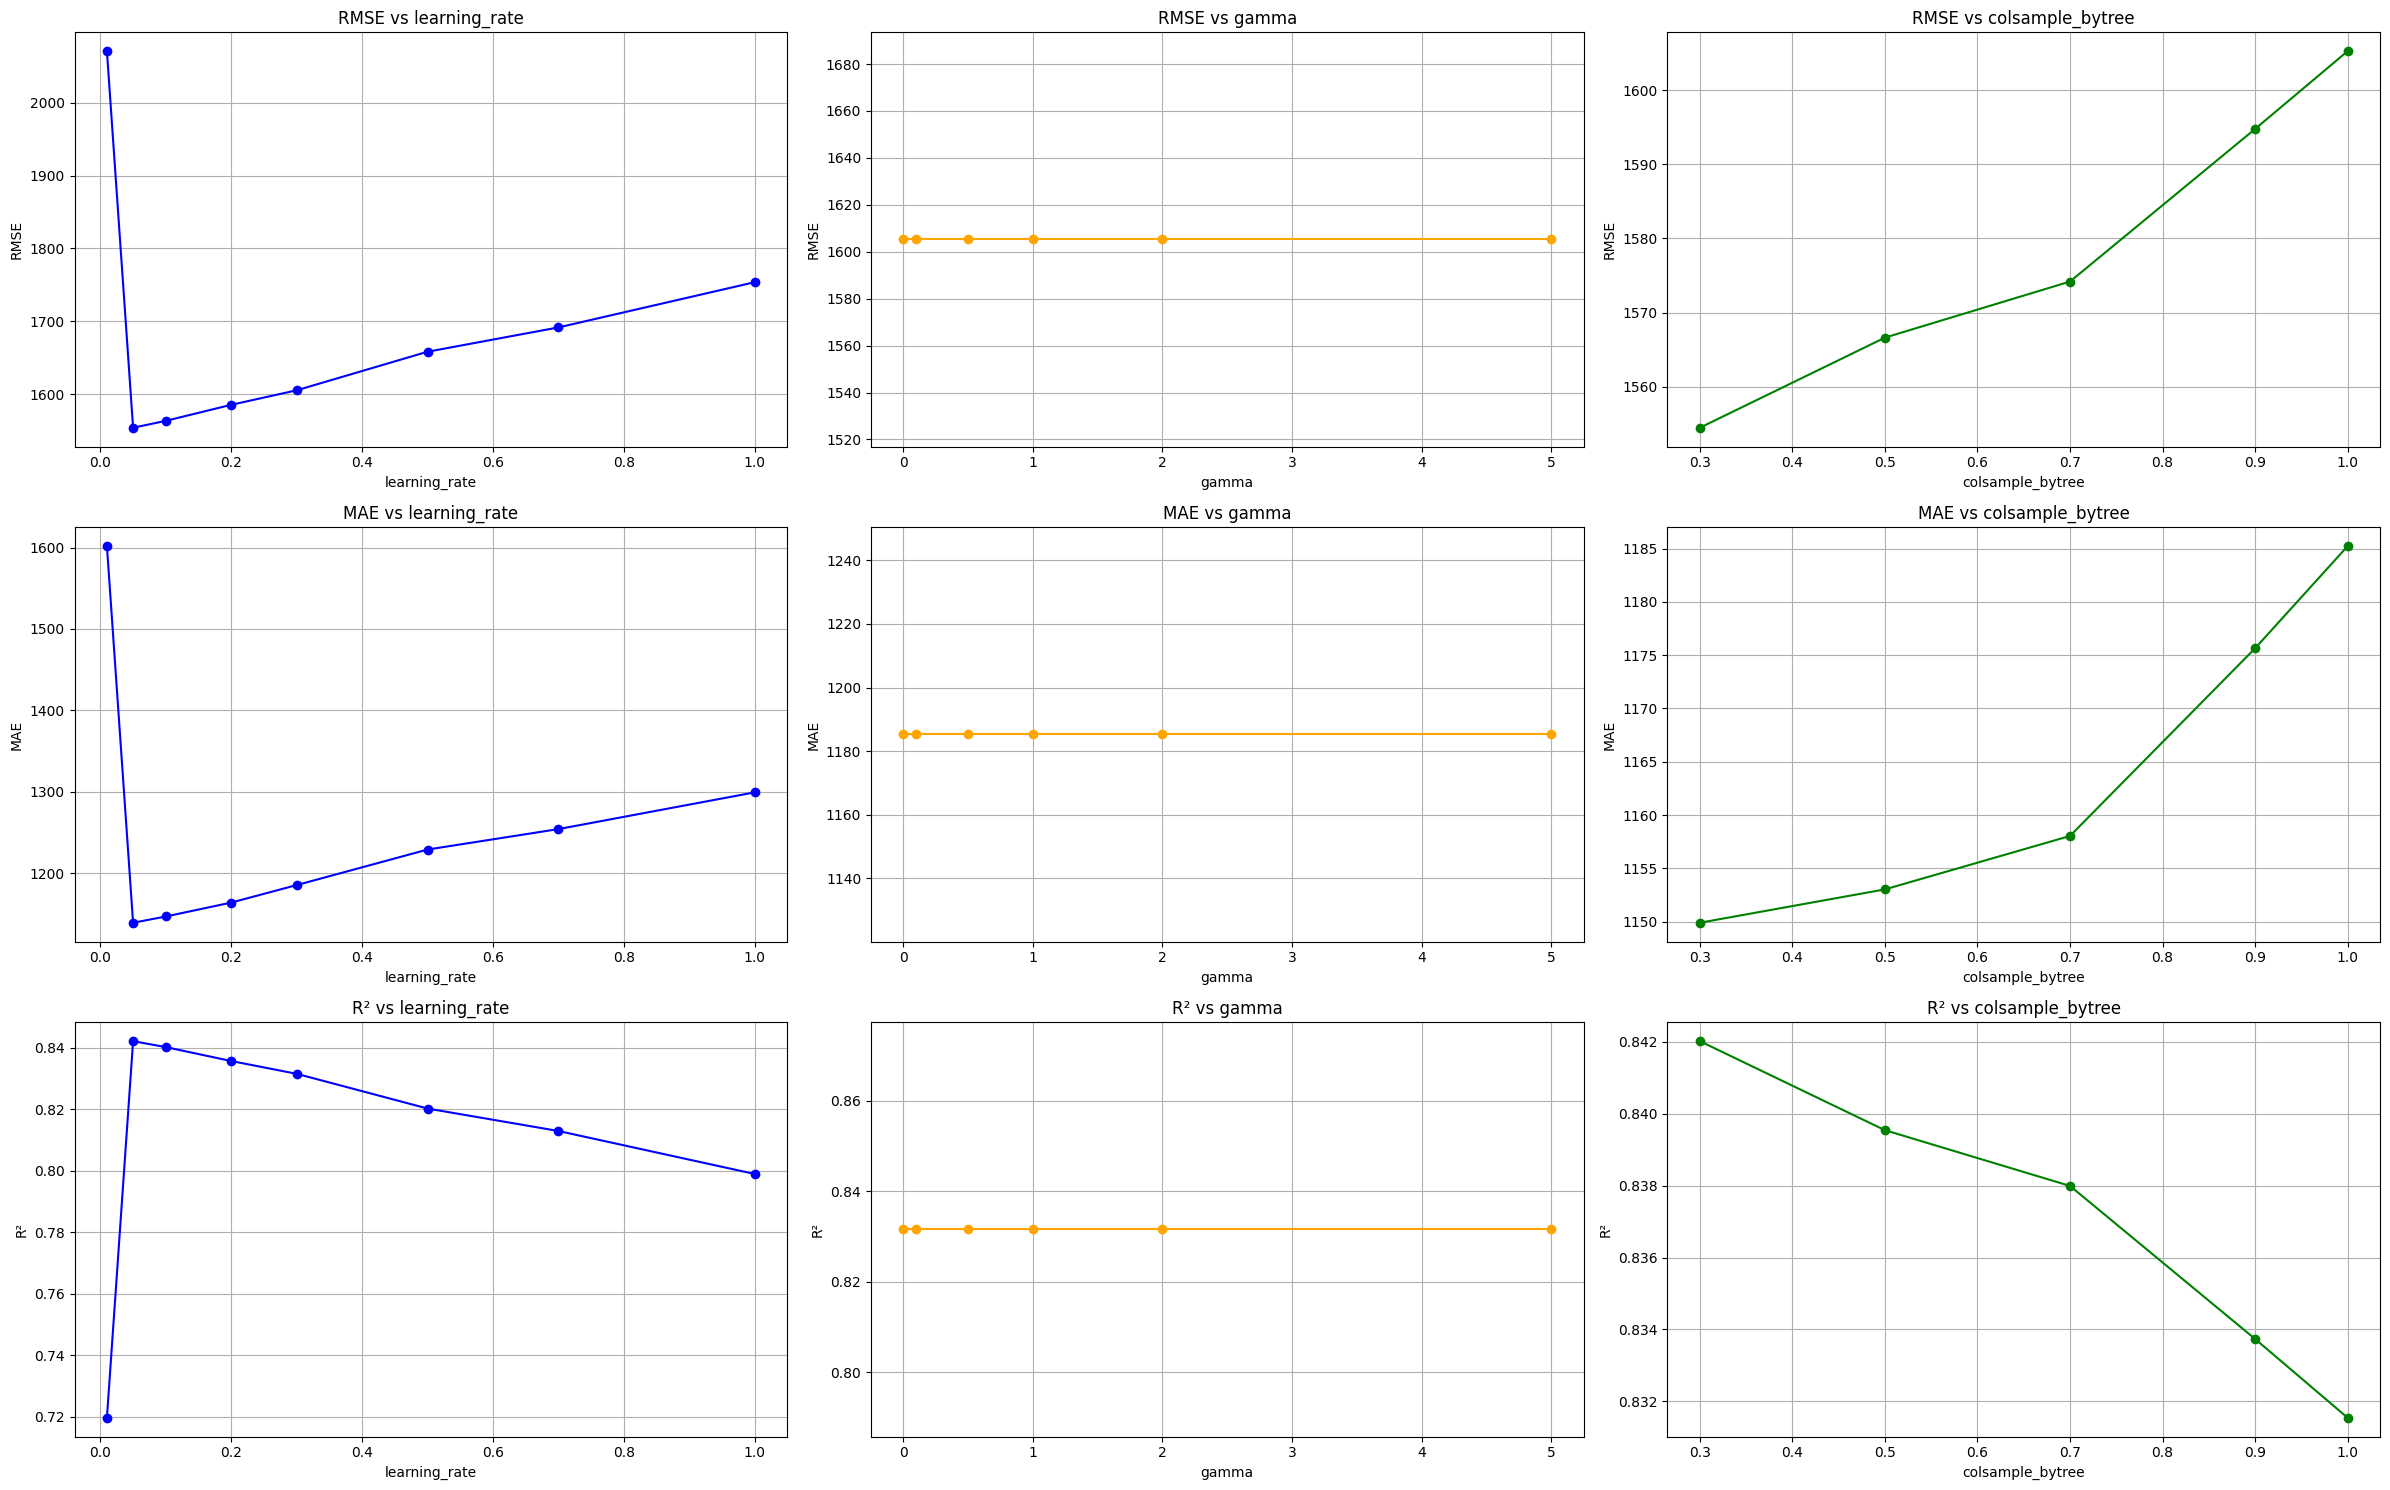

In [ ]:
### RMSE, MAE y R^2 segun valores de hiperparametros
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Valores a evaluar
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
gamma_values = [0, 0.1, 0.5, 1, 2, 5]
colsample_values = [0.3, 0.5, 0.7, 0.9, 1.0]

#listas para almacenar resultados
rmse_lr, mae_lr, r2_lr = [], [], []
rmse_gamma, mae_gamma, r2_gamma = [], [], []
rmse_colsample, mae_colsample, r2_colsample = [], [], []

# Evaluar learning_rate
for lr in learning_rates:
    model = XGBRegressor(learning_rate=lr, n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_lr.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_lr.append(mean_absolute_error(y_test, y_pred))
    r2_lr.append(r2_score(y_test, y_pred))

# Evaluar gamma
for gamma in gamma_values:
    model = XGBRegressor(gamma=gamma, n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_gamma.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_gamma.append(mean_absolute_error(y_test, y_pred))
    r2_gamma.append(r2_score(y_test, y_pred))

# Evaluar colsample_bytree
for cs in colsample_values:
    model = XGBRegressor(colsample_bytree=cs, n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_colsample.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_colsample.append(mean_absolute_error(y_test, y_pred))
    r2_colsample.append(r2_score(y_test, y_pred))

# Crear figura con 6 subplots (2 filas, 3 columnas)
fig, axs = plt.subplots(3, 3, figsize=(24, 15))

# Fila 1: RMSE
axs[0, 0].plot(learning_rates, rmse_lr, marker='o', color='blue')
axs[0, 0].set_title('RMSE vs learning_rate')
axs[0, 0].set_xlabel('learning_rate')
axs[0, 0].set_ylabel('RMSE')
axs[0, 0].grid(True)

axs[0, 1].plot(gamma_values, rmse_gamma, marker='o', color='orange')
axs[0, 1].set_title('RMSE vs gamma')
axs[0, 1].set_xlabel('gamma')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].grid(True)

axs[0, 2].plot(colsample_values, rmse_colsample, marker='o', color='green')
axs[0, 2].set_title('RMSE vs colsample_bytree')
axs[0, 2].set_xlabel('colsample_bytree')
axs[0, 2].set_ylabel('RMSE')
axs[0, 2].grid(True)

# Fila 2: MAE
axs[1, 0].plot(learning_rates, mae_lr, marker='o', color='blue')
axs[1, 0].set_title('MAE vs learning_rate')
axs[1, 0].set_xlabel('learning_rate')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].grid(True)

axs[1, 1].plot(gamma_values, mae_gamma, marker='o', color='orange')
axs[1, 1].set_title('MAE vs gamma')
axs[1, 1].set_xlabel('gamma')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].grid(True)

axs[1, 2].plot(colsample_values, mae_colsample, marker='o', color='green')
axs[1, 2].set_title('MAE vs colsample_bytree')
axs[1, 2].set_xlabel('colsample_bytree')
axs[1, 2].set_ylabel('MAE')
axs[1, 2].grid(True)

# Fila 3: R2
axs[2, 0].plot(learning_rates, r2_lr, marker='o', color='blue')
axs[2, 0].set_title('R² vs learning_rate')
axs[2, 0].set_xlabel('learning_rate')
axs[2, 0].set_ylabel('R²')
axs[2, 0].grid(True)

axs[2, 1].plot(gamma_values, r2_gamma, marker='o', color='orange')
axs[2, 1].set_title('R² vs gamma')
axs[2, 1].set_xlabel('gamma')
axs[2, 1].set_ylabel('R²')
axs[2, 1].grid(True)

axs[2, 2].plot(colsample_values, r2_colsample, marker='o', color='green')
axs[2, 2].set_title('R² vs colsample_bytree')
axs[2, 2].set_xlabel('colsample_bytree')
axs[2, 2].set_ylabel('R²')
axs[2, 2].grid(True)

# Ajustar espacio entre subplots
plt.tight_layout()
plt.show()

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

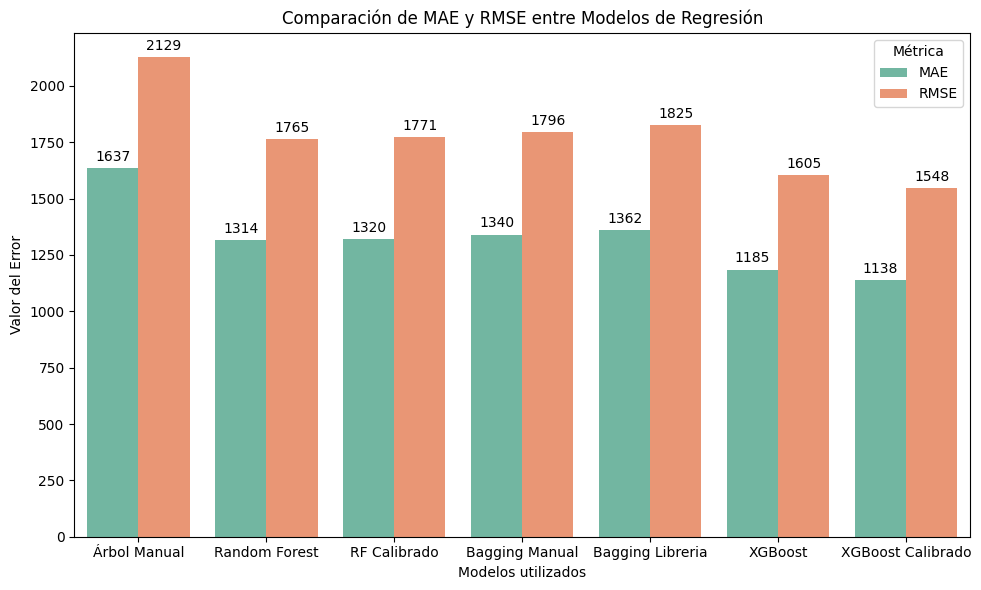

In [ ]:
# Celda 8
import seaborn as sns

datos = {
    'Modelo': ['Árbol Manual',
               'Random Forest',
               'RF Calibrado',
               'Bagging Manual',
               'Bagging Libreria',
               'XGBoost',
               'XGBoost Calibrado'],
    'MAE': [1637.13, 1314.42, mae_rf_calib, mae_bagging, mae_bag_libreria, mae_xg, mae_xg_calibrado],
    'RMSE': [2128.89, 1765.41, rmse_rf_calib, rmse_bagging, rmse_bag_libreria, rmse_xg, rmse_xg_calibrado]}

df_resultados = pd.DataFrame(datos)
df_melt = df_resultados.melt(id_vars='Modelo', var_name='Métrica', value_name='Error')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melt, x='Modelo', y='Error', hue='Métrica', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.title('Comparación de MAE y RMSE entre Modelos de Regresión')
plt.ylabel('Valor del Error')
plt.xlabel('Modelos utilizados')
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

🟢 Interpretación de los resultados.

1. Según la comparación de las metricas en el grafico, el mejor seria el XGBoost Calibrado ya que presenta el MAE y el RMSE más bajos. No obstante, este modelo mejoro solo ligeramente con su versión no calibrada, lo que demuestra que el XGBoost es el algorito que mejor predice sobre los demas modelos.
2. Seguido de estos, el tanto el Random Forest y su versión calibrada mostrarón un buen desempeño, aunque no tan buenos con el GXBoost, especialemnte en el RMSE.
3. En el caso de las dos versiones de Baggin, quedaron por detras del Random Forest, lo cual no es extraño si se piensa que el Random Forest introduce aletoriedad con variables, lo cual lo diferencia del bagging, y quiza eso explica sus resultados.
4. Claramente, el árbol manual es el modelo que peor predice los datos, lo cual no es extraño ya que el modelo tiende al sobreajuste y carece de la ventaja que tiene los modelos de ensamblaje.

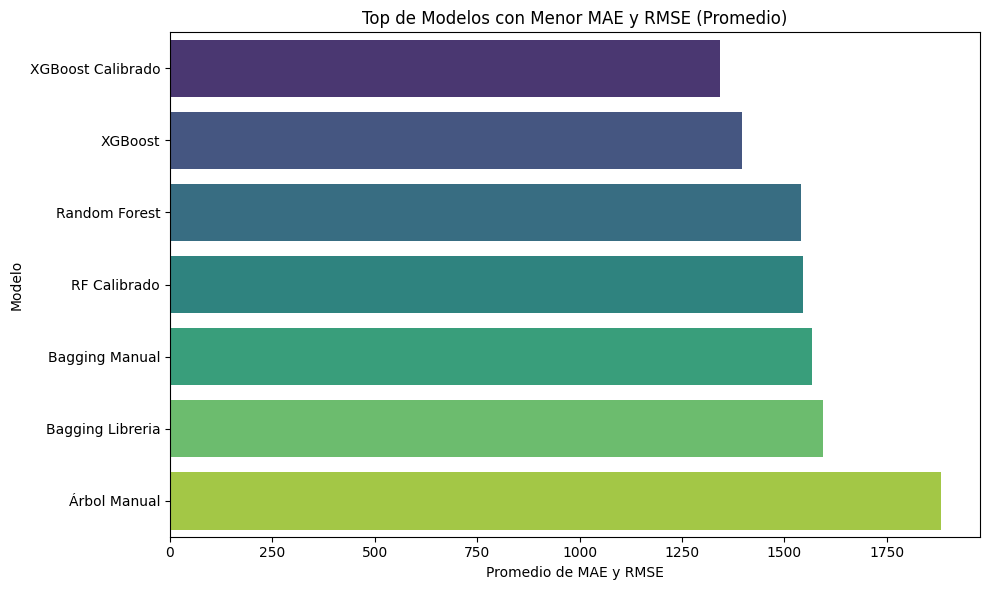

In [ ]:
top_mejores = pd.DataFrame(datos)

top_mejores['Promedio Error'] = (top_mejores['MAE'] + top_mejores['RMSE']) / 2

df_ordenado = top_mejores.sort_values('Promedio Error')

plt.figure(figsize=(10, 6))
sns.barplot(x='Promedio Error', y='Modelo', data=df_ordenado, palette='viridis')
plt.title('Top de Modelos con Menor MAE y RMSE (Promedio)')
plt.xlabel('Promedio de MAE y RMSE')
plt.ylabel('Modelo')
plt.tight_layout()
plt.show()